<a href="https://www.kaggle.com/code/mmellinger66/spaceship-titanic-xgb-lgbm-blend?scriptVersionId=102200626" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill">
    <h1 style="text-align: center;padding: 12px 0px 12px 0px;">Spaceship Titanic: XGBoost + LightGBM Blend</h1>
</div>

Ensembling models is important to doing well in Kaggle competitions.  This notebook is an attempt to combine two models, and build a foundation on which to combine several models.  Keeping this attempt simple, in accordance with the Telescope Rule:

Thomson's Rule for First-Time Telescope Makers: 

> "It is faster to make a four-inch mirror then a six-inch mirror than to make a six-inch mirror."

https://wiki.c2.com/?TelescopeRule

## The Learning Series

I'm taking a deep dive into solving the Spaceship Titanic learning competition by solving the problem using several different methods.  I'll try to resuse code in the notebooks.  Hopefully, this will be a learning experience for both myself and the readers.

## Notebooks in the Series

- [Spaceship Titanic: XGB+LGBM Blend](https://www.kaggle.com/code/mmellinger66/spaceship-titanic-xgb-lgbm-blend)
- [Spaceship Titanic: Voting Classifier](https://www.kaggle.com/code/mmellinger66/spaceship-titanic-voting-classifier)
- [Spaceship Titanic: XGBoost/Optuna](https://www.kaggle.com/code/mmellinger66/spaceship-titanic-xgboost-optuna)

In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [2]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

from itertools import cycle

plt.style.use("ggplot")  # ggplot, fivethirtyeight
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [3]:
class Config:
    path = "../input/spaceship-titanic"
    gpu = False
    debug = False
    optimize = False
    model_type = "tf"  # (xgb, cat, lgbm, keras)
    model_name = "tf1"
    competition = "spaceship-titanic"
    calc_probability = True
    seed = 42
    N_ESTIMATORS = 1000  # 100, 300, 2000, 5000 GBDT

    batch_size = 64
    epochs = 25
    N_FOLDS = 5  # 5,10,15
    SEED_LENGTH = 1  # 5,10

### The target/dependent variable in the dataset

In [4]:
# Was the passenger transported?
TARGET = "Transported"

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that will be reused in each project.

I need to be better with [DRY](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) on Kaggle.

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def create_submission(model_name, target, preds):
    sample_submission[target] = preds

    if len(model_name) > 0:
        fname = "submission_{model_name}.csv"
    else:
        fname = "submission.csv"

    sample_submission.to_csv(fname, index=False)

    return sample_submission

In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)


def show_scores(gt, yhat):
    accuracy = accuracy_score(gt, yhat)
    precision = precision_score(gt, yhat)
    recall = recall_score(gt, yhat)
    f1 = f1_score(gt, yhat)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"f1: {f1:.4f}")

In [8]:
from sklearn.preprocessing import LabelEncoder


def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [9]:
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = OneHotEncoder().fit_transform(train[col])
        test[col] = OneHotEncoder().fit_transform(test[col])
    return train, test

In [10]:
def show_missing_features(df):
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])

In [11]:
def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

In [12]:
def show_fold_scores(scores):
    cv_score = np.mean(scores)  # Used in filename
    print(
        f"Scores -> Adjusted: {np.mean(scores) - np.std(scores):.8f} , mean: {np.mean(scores):.8f}, std: {np.std(scores):.8f}"
    )

In [13]:
# Save OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

## Load the following files

 - train.csv - Data used to build our machine learning model
 - test.csv - Data used to build our machine learning model. Does not contain the `Transported` target variable
 - sample_submission.csv - A file in the proper format to submit test predictions

In [14]:
train, test, sample_submission = read_data(Config.path)

train data: Rows=8693, Columns=14
test data : Rows=4277, Columns=13


In [15]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [16]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [17]:
train = train.drop(columns=["Name"], axis=1).copy()
# test = test.drop(columns=["PassengerId"], axis=1).copy()

In [18]:
# ## Separate Categorical and Numerical Features
# cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
# num_features = list(test.select_dtypes(include=["number"]).columns)
# cat_features.remove("PassengerId")

# FEATURES = cat_features + num_features
# FEATURES

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

In [19]:
# train[FEATURES].head()

In [20]:
def create_features(df):
    df["Cabin"].fillna("Z/9999/Z", inplace=True)

    df["Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    del df["Cabin"]

    return df

In [21]:
train = create_features(train)
test = create_features(test)

## Categorical/Numerical Variables

In [22]:
## Separate Categorical and Numerical Features
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)
cat_features.remove("PassengerId")

FEATURES = cat_features + num_features
FEATURES

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Deck',
 'Side',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [23]:
train[FEATURES].head()

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,TRAPPIST-1e,False,B,P,39.0,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,False,F,S,24.0,109.0,9.0,25.0,549.0,44.0
2,Europa,False,TRAPPIST-1e,True,A,S,58.0,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,TRAPPIST-1e,False,A,S,33.0,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,TRAPPIST-1e,False,F,S,16.0,303.0,70.0,151.0,565.0,2.0


# Extract Target and Drop Unused Columns

In [24]:
# y = train[TARGET]

# X = train_df.drop(columns=["PassengerId", TARGET], axis=1).copy()
# X = train[FEATURES].copy()

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Missing Values</h1>
</div>

Note, handling missing data is an entire subject that should be studied in detail.  Kaggle offers a [course](https://www.kaggle.com/learn/data-cleaning)

- [sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/impute.html)
- https://scikit-learn.org/stable/modules/impute.html

- [A Guide to Handling Missing values in Python](https://www.kaggle.com/parulpandey/a-guide-to-handling-missing-values-in-python)

In [25]:
show_missing_features(train)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64


In [26]:
from sklearn.impute import SimpleImputer

# Categorical
imputer = SimpleImputer(strategy="most_frequent")

train[cat_features] = imputer.fit_transform(train[cat_features])
test[cat_features] = imputer.transform(test[cat_features])

# Numerical

# imputer = SimpleImputer(strategy="mean")
imputer = SimpleImputer(strategy="median")  # median is more robust to outliers

train[num_features] = imputer.fit_transform(train[num_features])
test[num_features] = imputer.transform(test[num_features])

### At this point we no longer have missing values

In [27]:
show_missing_features(train)

Series([], dtype: int64)


# Encoding Categorical Features

Need to convert categorical features into numerical features.

In [28]:
train, test = label_encoder(
    train, test, ["Destination", "HomePlanet", "CryoSleep", "VIP", "Deck", "Side"]
)
# X_test = pd.get_dummies(test[FEATURES], drop_first=True)

train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False,1,0
1,0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True,5,1
2,0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0,1
3,0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0,1
4,0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True,5,1


In [29]:
# y = train[TARGET]
# X = train[FEATURES].copy()

# X_test = test[FEATURES].copy()

In [30]:
train = create_folds(train, TARGET, Config.N_FOLDS)

TARGET=Transported, n_folds=5, seed=42


In [31]:
submission_df = test[["PassengerId"]].copy()
#
oof = train[["PassengerId", TARGET, "fold"]].copy().reset_index(drop=True).copy()
oof.set_index("PassengerId", inplace=True)
oof.head()

,Transported,fold
PassengerId,,
0001_01,False,4
0002_01,True,2
0003_01,False,2
0003_02,False,2
0004_01,True,3


In [32]:
# oof = train[["PassengerId", TARGET, "fold"]].set_index("PassengerId")
# oof.head()

## Train Model

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Train Model with Cross Validation</h1>
</div>

### Some common functions

In [33]:
def process_valid_predictions(final_valid_predictions, train_id, model_name):
    model = f"pred_{model_name}"
    final_valid_predictions_df = pd.DataFrame.from_dict(
        final_valid_predictions, orient="index"
    ).reset_index()
    final_valid_predictions_df.columns = [train_id, model]
    final_valid_predictions_df.set_index(train_id, inplace=True)
    final_valid_predictions_df.sort_index(inplace=True)
    final_valid_predictions_df.to_csv(f"train_pred_{model_name}.csv", index=False)

    return final_valid_predictions_df

In [34]:
from scipy.stats import mode


def merge_test_predictions(final_test_predictions, calc_probability=True):

    if Config.calc_probability:
        print("Mean")
        result = np.mean(np.column_stack(final_test_predictions), axis=1)
    else:
        print("Mode")
        mode_result = mode(np.column_stack(final_test_predictions), axis=1)
        result = mode_result[0].ravel()

    return result

In [35]:
def train_xgb_model(
    df,
    test,
    get_model_fn,
    FEATURES,
    TARGET,
    calc_probability,
    rowid,
    params,
    n_folds=5,
    seed=42,
):

    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    # oof_preds = np.zeros((df.shape[0],)) # Zero array
    # print(f"oof_preds size={df.shape[0]}")
    #     print(
    #         f"\n===== XGBoost Estimators: {params['n_estimators']}, Random State: {seed} ====="
    #     )

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = (
            xvalid.PassengerId.values.tolist()
        )  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]
        xtrain.head()
        #         print(f"{yvalid}")
        model = get_model_fn()

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            #             eval_metric="acc",  # auc
            verbose=False,
            #             early_stopping_rounds=3000,
            #             callbacks=[
            #                 xgb.log_evaluation(0),
            #                 xgb.early_stopping(500, False, True),
            #             ],
        )

        # Mean of the predictions
        #         preds_valid = model.predict(xvalid)
        #         test_preds = model.predict(xtest)
        if calc_probability:
            preds_valid = model.predict_proba(xvalid)[:, 1]
            test_preds = model.predict_proba(xtest)[:, 1]
        else:
            preds_valid = model.predict(xvalid)
            test_preds = model.predict(xtest)

        preds_valid_class = model.predict(xvalid)

        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        fold_score = accuracy_score(yvalid, preds_valid_class)  # Validation Set Score
        #         fold_score = roc_auc_score(yvalid, preds_valid)  # Validation Set Score

        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Accuracy: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )

In [36]:
xgb_params = {
    "enable_categorical": True,
    "objective": "binary:logistic",
    "eval_metric": "logloss",  # auc
    "n_estimators": Config.N_ESTIMATORS,
    "learning_rate": 0.021138659045230178,
    "subsample": 0.4,
    "colsample_bytree": 0.91,
    "max_depth": 17,
    "gamma": 0.6000000000000001,
    "booster": "gbtree",
    "tree_method": "hist",
    "reg_lambda": 0.005882742898970815,
    "reg_alpha": 0.0014501578157205654,
    "random_state": 42,
    "n_jobs": 4,
    "min_child_weight": 5.567082153821453,
}

In [37]:
def get_xgb_clf_model():
    #     model = xgb.XGBClassifier(n_estimators=1000)
    model = xgb.XGBClassifier(**xgb_params)
    return model

In [38]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html

lgbm_params = {
    "n_estimators": Config.N_ESTIMATORS,
    #     "device_type": "gpu",
    #     "objective": "multiclass",
    #     "metric": "multi_logloss",
    "objective": "binary",
    "metric": "accuracy",  # auc
    "lambda_l1": 0.009130931198077825,
    "lambda_l2": 3.530680683338868e-05,
    #     "reg_alpha": 0.009130931198077825,
    #     "reg_lambda": 3.530680683338868e-05,
    "num_leaves": 430,
    "importance_type": "split",
    #     "learning_rate": 0.029330486500731102,
    "learning_rate": 0.1,
    "feature_fraction": 0.8757445736567416,
    "bagging_fraction": 0.9989307214277753,
    "bagging_freq": 10,
    "min_child_samples": 20,
    "random_state": 42,
    "n_jobs": -1,
}
if Config.gpu:
    lgbm_params["device_type"] = "gpu"

In [39]:
def get_lgbm_clf_model():
    model = lgb.LGBMClassifier(**lgbm_params)
    return model

In [40]:
model_name = "xgb1"  # Make the code more generic

In [41]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train,
    test,
    get_xgb_clf_model,
    FEATURES,
    TARGET,
    Config.calc_probability,
    "PassengerId",
    xgb_params,
    Config.N_FOLDS,
    Config.seed,
)

========== Fold 1/5 ==========
fold: 1, Accuracy: 0.8050603795284647, Run Time: 5.83
========== Fold 2/5 ==========
fold: 2, Accuracy: 0.7912593444508338, Run Time: 5.85
========== Fold 3/5 ==========
fold: 3, Accuracy: 0.8079355951696378, Run Time: 5.75
========== Fold 4/5 ==========
fold: 4, Accuracy: 0.7974683544303798, Run Time: 5.83
========== Fold 5/5 ==========
fold: 5, Accuracy: 0.7871116225546605, Run Time: 5.82


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Scores</h1>
</div>

CV, or Cross Validation, Score.

We average the means and the standard deviations.

The Adjusted Score is the average of the means minus the average of standard deviation. Do this to attempt to get one number to evaluate the score when comparing different models.

In [42]:
show_fold_scores(fold_scores)

Scores -> Adjusted: 0.78986049 , mean: 0.79776706, std: 0.00790657


In [43]:
final_valid_predictions_df = process_valid_predictions(
    final_valid_predictions, "id", model_name
)
final_valid_predictions_df.head()

,pred_xgb1
id,
0001_01,0.533496
0002_01,0.110731
0003_01,0.024523
0003_02,0.010004
0004_01,0.125169


In [44]:
oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]
oof.head()

,Transported,fold,pred_xgb1
PassengerId,,,
0001_01,False,4,0.533496
0002_01,True,2,0.110731
0003_01,False,2,0.024523
0003_02,False,2,0.010004
0004_01,True,3,0.125169


In [45]:
result = merge_test_predictions(final_test_predictions, Config.calc_probability)
result[:20]

Mean


array([0.633851  , 0.00893717, 0.9982313 , 0.9918618 , 0.46233052,
       0.41439748, 0.99381673, 0.9945488 , 0.9955398 , 0.58458996,
       0.15587609, 0.04784193, 0.46154547, 0.47209543, 0.00777313,
       0.06356245, 0.14164837, 0.99740773, 0.8883047 , 0.01780986],
      dtype=float32)

In [46]:
# submission_df["target_xgb1"] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission_df[f"target_{model_name}"] = result
submission_df.head(10)

,PassengerId,target_xgb1
0,0013_01,0.633851
1,0018_01,0.008937
2,0019_01,0.998231
3,0021_01,0.991862
4,0023_01,0.462331
5,0027_01,0.414397
6,0029_01,0.993817
7,0032_01,0.994549
8,0032_02,0.995540
9,0033_01,0.584590


In [47]:
ss = (
    submission_df[["PassengerId", f"target_{model_name}"]].copy().reset_index(drop=True)
)
ss.rename(columns={f"target_{model_name}": TARGET}, inplace=True)
ss

,PassengerId,Transported
0,0013_01,0.633851
1,0018_01,0.008937
2,0019_01,0.998231
3,0021_01,0.991862
4,0023_01,0.462331
...,...,...
4272,9266_02,0.766751
4273,9269_01,0.239492
4274,9271_01,0.962422
4275,9273_01,0.866816


In [48]:
ss[TARGET] = np.rint(ss[TARGET]).astype(bool)
ss.to_csv(
    f"submission_{model_name}.csv", index=False
)  # Can submit the individual model
ss.head(10)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
5,0027_01,False
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


## LGBM Model

In [49]:
model_name = "lgbm1"  # Make the code more generic

In [50]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train,
    test,
    get_lgbm_clf_model,
    FEATURES,
    TARGET,
    Config.calc_probability,
    "PassengerId",
    lgbm_params,
    Config.N_FOLDS,
    Config.seed,
)

========== Fold 1/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 1, Accuracy: 0.7947096032202415, Run Time: 7.04
========== Fold 2/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 2, Accuracy: 0.7826336975273146, Run Time: 7.18
========== Fold 3/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 3, Accuracy: 0.7872340425531915, Run Time: 6.58
========== Fold 4/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 4, Accuracy: 0.7928653624856157, Run Time: 6.55
========== Fold 5/5 ==========
[LightGBM] [Warning] lambda_l1 is set=0.009130931198077825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009130931198077825
[LightGBM] [Warning] bagging_fraction is set=0.9989307214277753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989307214277753
[LightGBM] [Warning] feature_fraction is set=0.8757445736567416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757445736567416
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=3.530680683338868e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.530680683338868e-05


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 5, Accuracy: 0.7871116225546605, Run Time: 7.50


In [51]:
show_fold_scores(fold_scores)

Scores -> Adjusted: 0.78455850 , mean: 0.78891087, std: 0.00435236


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Save OOF Predictions</h1>
</div>

This is unused for this example but needed later for [Blending](https://towardsdatascience.com/ensemble-learning-stacking-blending-voting-b37737c4f483).

**General idea**: The values will be use to create new features in a blended model.

- [Stacking and Blending — An Intuitive ExplanationStacking and Blending — An Intuitive Explanation](https://medium.com/@stevenyu530_73989/stacking-and-blending-intuitive-explanation-of-advanced-ensemble-methods-46b295da413chttps://medium.com/@stevenyu530_73989/stacking-and-blending-intuitive-explanation-of-advanced-ensemble-methods-46b295da413c)

In [52]:
final_valid_predictions_df = process_valid_predictions(
    final_valid_predictions, "PassengerId", model_name
)
final_valid_predictions_df.head()

,pred_lgbm1
PassengerId,
0001_01,0.901365
0002_01,0.000180
0003_01,0.000017
0003_02,0.000003
0004_01,0.006706


In [53]:
oof[f"pred_{model_name}"] = final_valid_predictions_df[f"pred_{model_name}"]
oof.head()

,Transported,fold,pred_xgb1,pred_lgbm1
PassengerId,,,,
0001_01,False,4,0.533496,0.901365
0002_01,True,2,0.110731,0.000180
0003_01,False,2,0.024523,0.000017
0003_02,False,2,0.010004,0.000003
0004_01,True,3,0.125169,0.006706


In [54]:
result = merge_test_predictions(final_test_predictions, Config.calc_probability)
result[:20]

Mean


array([6.36944658e-01, 2.70235087e-06, 9.99999914e-01, 9.99995414e-01,
       3.33810365e-01, 9.09884704e-02, 9.99998016e-01, 9.99999908e-01,
       9.99998722e-01, 6.59507540e-01, 1.71843684e-03, 6.88136196e-04,
       2.38690010e-01, 1.08225699e-01, 3.16923074e-06, 7.56467491e-05,
       1.82110641e-02, 9.99999968e-01, 9.81443174e-01, 2.82160013e-05])

In [55]:
submission_df[f"target_{model_name}"] = result
submission_df.head(10)

,PassengerId,target_xgb1,target_lgbm1
0,0013_01,0.633851,0.636945
1,0018_01,0.008937,0.000003
2,0019_01,0.998231,1.000000
3,0021_01,0.991862,0.999995
4,0023_01,0.462331,0.333810
5,0027_01,0.414397,0.090988
6,0029_01,0.993817,0.999998
7,0032_01,0.994549,1.000000
8,0032_02,0.995540,0.999999
9,0033_01,0.584590,0.659508


In [56]:
ss = (
    submission_df[["PassengerId", f"target_{model_name}"]].copy().reset_index(drop=True)
)
ss.rename(columns={f"target_{model_name}": TARGET}, inplace=True)
ss

,PassengerId,Transported
0,0013_01,0.636945
1,0018_01,0.000003
2,0019_01,1.000000
3,0021_01,0.999995
4,0023_01,0.333810
...,...,...
4272,9266_02,0.979953
4273,9269_01,0.283715
4274,9271_01,0.997130
4275,9273_01,0.987602


In [57]:
ss[TARGET] = np.rint(ss[TARGET]).astype(bool)
ss.to_csv(f"submission_{model_name}.csv", index=False)
ss.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Weighted Blend Based on OOF</h1>
</div>

In [58]:
oof.head()

,Transported,fold,pred_xgb1,pred_lgbm1
PassengerId,,,,
0001_01,False,4,0.533496,0.901365
0002_01,True,2,0.110731,0.000180
0003_01,False,2,0.024523,0.000017
0003_02,False,2,0.010004,0.000003
0004_01,True,3,0.125169,0.006706


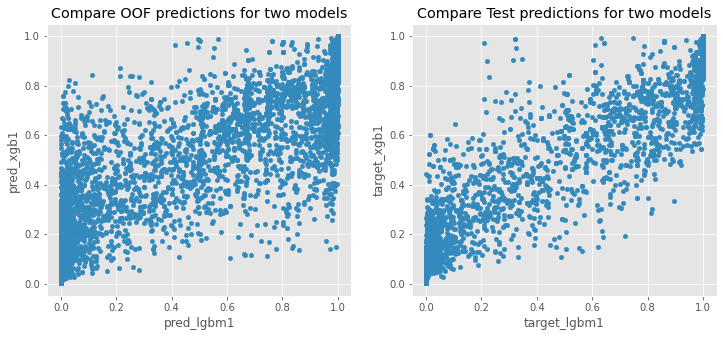

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
oof.plot(
    x="pred_lgbm1",
    y="pred_xgb1",
    kind="scatter",
    title="Compare OOF predictions for two models",
    ax=axs[0],
)

submission_df.plot(
    x="target_lgbm1",
    y="target_xgb1",
    kind="scatter",
    title="Compare Test predictions for two models",
    ax=axs[1],
)
plt.show()

In [60]:
oof.head()

,Transported,fold,pred_xgb1,pred_lgbm1
PassengerId,,,,
0001_01,False,4,0.533496,0.901365
0002_01,True,2,0.110731,0.000180
0003_01,False,2,0.024523,0.000017
0003_02,False,2,0.010004,0.000003
0004_01,True,3,0.125169,0.006706


In [61]:
def get_oof_accuracy_score(weight, oof, pred_model1, pred_model2):
    blend_pred = (oof[pred_model1] * weight) + (oof[pred_model2] * (1 - weight))
    blend_int = np.rint(blend_pred).astype(int)
    score = accuracy_score(oof[TARGET], blend_int)
    return score

In [62]:
myscores = {}
best = 0
best_weight = 0

for weight in range(100):
    weight /= 100
    score = get_oof_accuracy_score(weight, oof, "pred_xgb1", "pred_lgbm1")
    if score > best:
        best = score
        best_weight = weight
        print(f"Best Weight: {best_weight},Score {best}")
    myscores[weight] = score

Best Weight: 0.0,Score 0.7889106177384102
Best Weight: 0.01,Score 0.7892557229955136
Best Weight: 0.02,Score 0.789600828252617
Best Weight: 0.09,Score 0.7897158633383182
Best Weight: 0.1,Score 0.7900609685954216
Best Weight: 0.11,Score 0.7901760036811227
Best Weight: 0.32,Score 0.790406073852525
Best Weight: 0.33,Score 0.7906361440239273
Best Weight: 0.34,Score 0.7910962843667319
Best Weight: 0.35,Score 0.791211319452433
Best Weight: 0.36,Score 0.7916714597952376
Best Weight: 0.37,Score 0.7917864948809387
Best Weight: 0.38,Score 0.7919015299666399
Best Weight: 0.39,Score 0.7921316001380421
Best Weight: 0.4,Score 0.7923616703094444
Best Weight: 0.46,Score 0.7927067755665478
Best Weight: 0.47,Score 0.7928218106522489
Best Weight: 0.51,Score 0.7930518808236512
Best Weight: 0.53,Score 0.7932819509950535
Best Weight: 0.54,Score 0.793742091337858
Best Weight: 0.55,Score 0.7938571264235592
Best Weight: 0.56,Score 0.7940871965949614
Best Weight: 0.58,Score 0.7944323018520649
Best Weight: 0.59,

In [63]:
blend_results = pd.DataFrame(myscores, index=["score"]).T

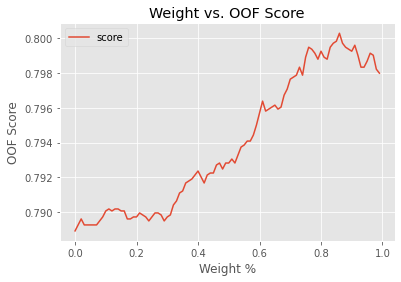

In [64]:
ax = blend_results.plot(title="Weight vs. OOF Score")
ax.set_ylabel("OOF Score")
ax.set_xlabel("Weight %")

plt.show()

### The Blended Weight is ...

In [65]:
blend_results.loc[blend_results["score"] == blend_results["score"].max()]

,score
0.86,0.800299


In [66]:
blend_score = blend_results["score"].max()
print(f"Blended Score: {blend_score:.8f}")

Blended Score: 0.80029909


In [67]:
w = blend_results.loc[blend_results["score"] == blend_results["score"].max()]
w

,score
0.86,0.800299


In [68]:
wt = w.first_valid_index()
wt

0.86

In [69]:
blend_results["score"]

0.00    0.788911
0.01    0.789256
0.02    0.789601
0.03    0.789256
0.04    0.789256
          ...   
0.95    0.798689
0.96    0.799149
0.97    0.799034
0.98    0.798228
0.99    0.797998
Name: score, Length: 100, dtype: float64

<div style="background-color:rgba(255, 215, 0, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Submission File</h1>
</div>

In [70]:
submission_df.head()

,PassengerId,target_xgb1,target_lgbm1
0,0013_01,0.633851,0.636945
1,0018_01,0.008937,0.000003
2,0019_01,0.998231,1.000000
3,0021_01,0.991862,0.999995
4,0023_01,0.462331,0.333810


In [71]:
print(f"Weights=({wt}, {1-wt})")

sample_submission[TARGET] = (submission_df["target_xgb1"] * wt) + (
    submission_df["target_lgbm1"] * (1 - wt)
)
sample_submission.head(8)

Weights=(0.86, 0.14)


,PassengerId,Transported
0,0013_01,0.634284
1,0018_01,0.007686
2,0019_01,0.998479
3,0021_01,0.993001
4,0023_01,0.444338
5,0027_01,0.369120
6,0029_01,0.994682
7,0032_01,0.995312


In [72]:
sample_submission[TARGET] = np.rint(sample_submission[TARGET]).astype(bool)
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head(8)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
5,0027_01,False
6,0029_01,True
7,0032_01,True
